# Inception V3

### InceptionV3 with only 2 categories (Benign and Malign)

## Get packages

In [7]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
import albumentations as A 
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize
import matplotlib.pyplot as plt


from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.legacy import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras import models
from keras.preprocessing import image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Paths

In [2]:
TRAIN_PATH = 'archive/classification/simple/train'
TEST_PATH = 'archive/classification/simple/test'
VALID_PATH = 'archive/classification/simple/validate'

In [ ]:
# input_size = (3,224,224)

## Load and Prepare Images

In [8]:
from keras.preprocessing.image import ImageDataGenerator

# train_batchsize = 4
# valid_batchsize = 4

train_datagen = ImageDataGenerator(
        rescale = 1./255.,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=0.6)

validation_datagen = ImageDataGenerator(
        rescale = 1./255.,
    )
                                  

train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  
        shuffle=True,
#          batch_size=train_batchsize,
        target_size = (150, 150),
        class_mode='categorical')  

validation_generator = validation_datagen.flow_from_directory(
        VALID_PATH,  
        target_size = (150, 150),
        shuffle=True,
#          batch_size=valid_batchsize,
        class_mode='categorical')

Found 520 images belonging to 2 classes.
Found 174 images belonging to 2 classes.


## Make the model

In [9]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [33]:
# from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(2, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)
# Print a summary of the model architecture
model.summary()

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
#     loss=keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.legacy.SGD(),  
    metrics = ['accuracy'])


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalization_94

                                                                                                  
 conv2d_105 (Conv2D)         (None, 16, 16, 32)           6144      ['average_pooling2d_9[0][0]'] 
                                                                                                  
 batch_normalization_99 (Ba  (None, 16, 16, 64)           192       ['conv2d_99[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_101 (B  (None, 16, 16, 64)           192       ['conv2d_101[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_104 (B  (None, 16, 16, 96)           288       ['conv2d_104[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_111 (Activation  (None, 16, 16, 96)           0         ['batch_normalization_111[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_112 (Activation  (None, 16, 16, 64)           0         ['batch_normalization_112[0][0
 )                                                                  ]']                           
                                                                                                  
 mixed1 (Concatenate)        (None, 16, 16, 288)          0         ['activation_106[0][0]',      
                                                                     'activation_108[0][0]',      
          

 )                                                                  ]']                           
                                                                                                  
 conv2d_122 (Conv2D)         (None, 16, 16, 96)           55296     ['activation_121[0][0]']      
                                                                                                  
 batch_normalization_122 (B  (None, 16, 16, 96)           288       ['conv2d_122[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_122 (Activation  (None, 16, 16, 96)           0         ['batch_normalization_122[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_12

                                                                                                  
 conv2d_124 (Conv2D)         (None, 7, 7, 192)            147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_127 (Conv2D)         (None, 7, 7, 192)            172032    ['activation_126[0][0]']      
                                                                                                  
 conv2d_132 (Conv2D)         (None, 7, 7, 192)            172032    ['activation_131[0][0]']      
                                                                                                  
 conv2d_133 (Conv2D)         (None, 7, 7, 192)            147456    ['average_pooling2d_12[0][0]']
                                                                                                  
 batch_normalization_124 (B  (None, 7, 7, 192)            576       ['conv2d_124[0][0]']          
 atchNorma

 activation_141 (Activation  (None, 7, 7, 160)            0         ['batch_normalization_141[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_13 (Aver  (None, 7, 7, 768)            0         ['mixed4[0][0]']              
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_134 (Conv2D)         (None, 7, 7, 192)            147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_137 (Conv2D)         (None, 7, 7, 192)            215040    ['activation_136[0][0]']      
                                                                                                  
 conv2d_14

 atchNormalization)                                                                               
                                                                                                  
 activation_146 (Activation  (None, 7, 7, 160)            0         ['batch_normalization_146[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_151 (Activation  (None, 7, 7, 160)            0         ['batch_normalization_151[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_14 (Aver  (None, 7, 7, 768)            0         ['mixed5[0][0]']              
 agePooling2D)                                                                                    
          

                                                                                                  
 batch_normalization_156 (B  (None, 7, 7, 192)            576       ['conv2d_156[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_161 (B  (None, 7, 7, 192)            576       ['conv2d_161[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_156 (Activation  (None, 7, 7, 192)            0         ['batch_normalization_156[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 )                                                                  ]']                           
                                                                                                  
 conv2d_165 (Conv2D)         (None, 3, 3, 320)            552960    ['activation_164[0][0]']      
                                                                                                  
 conv2d_169 (Conv2D)         (None, 3, 3, 192)            331776    ['activation_168[0][0]']      
                                                                                                  
 batch_normalization_165 (B  (None, 3, 3, 320)            960       ['conv2d_165[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_169 (B  (None, 3, 3, 192)            576       ['conv2d_169[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_176 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_176[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_177 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_177[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_178 (B  (None, 3, 3, 192)            576       ['conv2d_178[0][0]']          
 atchNormalization)                                                                               
          

 )                                                                  ]']                           
                                                                                                  
 activation_182 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_182[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_185 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_185[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_186 (Activation  (None, 3, 3, 384)            0         ['batch_normalization_186[0][0
 )                                                                  ]']                           
          

## Train the model

In [34]:
# Saving the best result
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model_inception_simple_aug.h5', verbose=1, save_best_only=True)

callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkpoiter

]
# Train
results = model.fit(train_generator, 
                    validation_data=validation_generator, 
#                      validation_split=0.1, 
                    batch_size=32, 
                    epochs=25, 
                    callbacks=callbacks,
#                     steps_per_epoch=10
                   )

Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 0.9184 - accuracy: 0.7673
Epoch 1: val_loss improved from inf to 0.67421, saving model to model_inception_simple_aug.h5
17/17 [==============================] - 8s 394ms/step - loss: 0.9184 - accuracy: 0.7673 - val_loss: 0.6742 - val_accuracy: 0.8161
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 0.4848 - accuracy: 0.8250
Epoch 2: val_loss improved from 0.67421 to 0.52708, saving model to model_inception_simple_aug.h5
17/17 [==============================] - 7s 383ms/step - loss: 0.4848 - accuracy: 0.8250 - val_loss: 0.5271 - val_accuracy: 0.7931
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 0.4685 - accuracy: 0.7904
Epoch 3: val_loss did not improve from 0.52708
17/17 [==============================] - 7s 386ms/step - loss: 0.4685 - accuracy: 0.7904 - val_loss: 0.6662 - val_accuracy: 0.8161
Epoch 4/25
17/17 [==============================] - ETA: 0s - loss: 0.4348 - accuracy:

## Results

In [31]:
print('Accuracy Score = ',np.max(results.history['val_accuracy']))
print('Loss Score = ',np.min(results.history['val_loss']))

Accuracy Score =  0.8160919547080994
Loss Score =  0.604697048664093


### During training

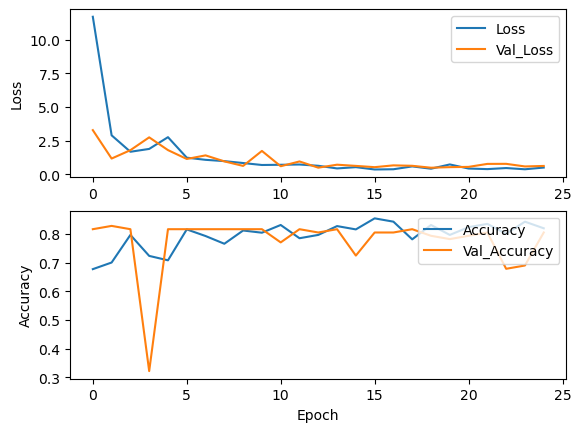

In [33]:
plt.figure()
plt.subplot(211)
loss_train_curve = results.history["loss"]
loss_val_curve = results.history["val_loss"]
plt.plot(loss_train_curve, label = "Loss")
plt.plot(loss_val_curve, label = "Val_Loss")
plt.legend(loc = 'upper right')
plt.ylabel("Loss")


plt.subplot(212)
acc_train_curve = results.history["accuracy"]
acc_val_curve = results.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Accuracy")
plt.plot(acc_val_curve, label = "Val_Accuracy")
plt.legend(loc = 'upper right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()